In [403]:
# Parameters
artificial_humans = "../data/dev/data/model.pt"
output_file = "../data/dev/data/manager_run.pt"
model_args = {"n_layers": 2, "hidden_size": 40}
opt_args = {'lr': 0.001}
gamma = 1.0
eps = 0.2
target_update_freq = 10
n_episode_steps = 16
n_episodes = 1000
sample_args = {
    'batch_size': 10,
    'horizon': 1000
}

In [404]:
%load_ext autoreload
%autoreload 2

import torch as th
from aimanager.model.memory import Memory
from aimanager.model.environment import ArtificialHumanEnv
from aimanager.model.artificial_humans import ArtificialHuman
from aimanager.model.neural.mlp import MultiLayer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [405]:
import torch as th
import numpy as np

# def shift_obs(tensor_dict):
#     """
#     Creates previous and current observations.

#     Args:
#         tensor_dict: each tensor need to have the episode_step dimension at second position
#     """
#     previous = {k: t[:, :-1] for k, t in tensor_dict.items()}
#     current = {k: t[:, 1:] for k, t in tensor_dict.items()}
#     return previous, current


class ArtificalManager():
    def __init__(
            self, *, n_contributions, n_punishments, model_args, opt_args, gamma, target_update_freq, device):
        self.device = device
        input_size = n_contributions
        self.policy_model = MultiLayer(output_size=n_punishments+1, input_size=input_size, **model_args).to(device)
        self.target_model = MultiLayer(output_size=n_punishments+1, input_size=input_size, **model_args).to(device)

        self.target_model.eval()
        self.optimizer = th.optim.RMSprop(self.policy_model.parameters(), **opt_args)
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.n_contributions = n_contributions
        self.n_punishments = n_punishments

    def init_episode(self, episode):
        if (episode % self.target_update_freq == 0):
            # copy policy net to target net
            self.target_model.load_state_dict(self.policy_model.state_dict())

        # TODO: add for rnn
        # self.policy_model.reset()
        # self.target_model.reset()

    def encode_obs(self, contributions, episode_step, **_):
        oh_cont = th.nn.functional.one_hot(contributions, num_classes=self.n_contributions).float()
        es = episode_step.unsqueeze(-1).tile((1,4)).float() / 16
        print(oh_cont.shape)
        print(es.shape)

        return th.cat([oh_cont, es], dim=-1)

    def get_q(self, manager_observations, **_):
        with th.no_grad():
            return self.policy_model(manager_observations)

    def act(self, **state):
        obs = self.encode_obs(**state)
        q = self.get_q(manager_observations=obs)
        return q.argmax(dim=-1)

    def eps_greedy(self, q_values, eps):
        """
        Args:
            q_values: Tensor of type `th.float` and arbitrary shape, last dimension reflect the actions.
            eps: fraction of actions sampled at random
        Returns:
            actions: Tensor of type `th.long` and the same dimensions then q_values, besides of the last.
        """
        n_actions = q_values.shape[-1]
        actions_shape = q_values.shape[:-1]

        greedy_actions = q_values.argmax(-1)
        random_actions = th.randint(0, n_actions, size=actions_shape, device=self.device)

        # random number which determine whether to take the random action
        random_numbers = th.rand(size=actions_shape, device=device)
        select_random = (random_numbers < eps).long()
        picked_actions = select_random * random_actions + (1 - select_random) * greedy_actions

        return picked_actions


    def update(self, actions, rewards, current_obs, next_obs, **_):
        self.policy_model.train()
        current_state_action_values = self.policy_model(
            current_obs).gather(-1, actions.unsqueeze(-1))

        next_state_values = th.zeros_like(rewards, device=self.device)
        next_state_values[:,:-1] = self.target_model(next_obs[:,:-1]).max(-1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + rewards

        # Compute Huber loss
        loss = th.nn.functional.smooth_l1_loss(current_state_action_values,
                                               expected_state_action_values.unsqueeze(-1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [406]:
# from aimanager.model.neural.random import RandomArtificialHumans

device = th.device('cpu')
rec_device = th.device('cpu')
# rah = RandomArtificialHumans(device=device, max_contribution=20)
artifical_humans = ArtificialHuman.load(artificial_humans)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, episode_steps=n_episode_steps, device=device)

In [407]:
# state = env.init_episode()
# print(state)
# done = False
# while not done:
#     punishments = th.randint(0, 31, (4,), device=device)
#     state, reward, done = env.step(punishments)
#     print(state, reward, done)


In [408]:
from itertools import count


manager = ArtificalManager(
    n_contributions=21, n_punishments=31, model_args=model_args, opt_args=opt_args, gamma=gamma, 
    target_update_freq=target_update_freq, device=device)

replay_mem = Memory(n_episodes=100, n_episode_steps=n_episode_steps-1, output_file=None, device=device)
recorder = Memory(n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=output_file, device=device)


for episode in range(n_episodes):
    if (episode > 1) and (episode % 200 == 0):
        print(f'Start episode {episode}.')
        # print(recorder.memory['common_good'].sum()/len(recorder))
        print(replay_mem.memory['rewards'].sum()/len(replay_mem))

    state = env.init_episode()

    # initialize episode for all controller
    manager.init_episode(episode)
    # state_enc = manager.encode_obs(**state)
    # replay_mem.add(episode_step=0, actions=th.zeros(4, dtype=th.int64), rewards=th.zeros(4, dtype=th.float), **state_enc)
    
    current_obs = manager.encode_obs(**state)
    for step in count():
        # Get observations
        # break

        # Get q values from controller
        q_values = manager.get_q(manager_observations=current_obs)

        # Sample a action
        selected_actions = manager.eps_greedy(q_values=q_values, eps=eps)

        state = env.punish(selected_actions)
        recorder.add(**state)

        # pass actions to environment and advance by one step
        state, rewards, done = env.step()


        # if (episode > 1) and (episode % 50 == 0)and (step == 3):
        #     print(q_values[0], selected_actions, rewards)
        if done:
            replay_mem.add(
                episode_step=step, actions=selected_actions, rewards=rewards, 
                current_obs=current_obs)
        else:
            next_obs = manager.encode_obs(**state)
            replay_mem.add(
                episode_step=step, actions=selected_actions, rewards=rewards, 
                current_obs=current_obs, next_obs=next_obs)
            current_obs = next_obs
        
        if done:
            # allow all controller to update themself
            sample = replay_mem.sample(**sample_args)
            if sample is not None:
                actions = sample['actions']
                rewards = sample['rewards']
                current_obs = sample['current_obs']
                next_obs = sample['next_obs']
                current_state_action_values = manager.policy_model(
                    current_obs).gather(-1, actions.unsqueeze(-1))

                next_state_values = th.zeros_like(rewards, device=manager.device)
                next_state_values[:,:-1] = manager.target_model(next_obs[:,:-1]).max(-1)[0].detach()

                # Compute the expected Q values
                expected_state_action_values = (next_state_values * manager.gamma) + rewards

                # Compute Huber loss
                loss = th.nn.functional.smooth_l1_loss(
                    current_state_action_values, expected_state_action_values.unsqueeze(-1))

                # Optimize the model
                manager.optimizer.zero_grad()
                loss.backward()
                for param in manager.policy_model.parameters():
                    param.grad.data.clamp_(-1, 1)
                manager.optimizer.step()

                # manager.update(**sample)
            break
    # if sample is not None:
    #     break
    recorder.add(**state)
    recorder.next_episode(episode)
    replay_mem.next_episode(episode)
    # break

# current_obs

torch.Size([4, 21])
torch.Size([1])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4 but got size 1 for tensor number 1 in the list.

In [ ]:
data = {
    'contributions': th.arange(0,21)
}

# obs = manager.

data['punishments'] = manager.act(**data)


In [ ]:
obs = manager.encode_obs(**data)
q = manager.get_q(manager_observations=obs)



<AxesSubplot:>

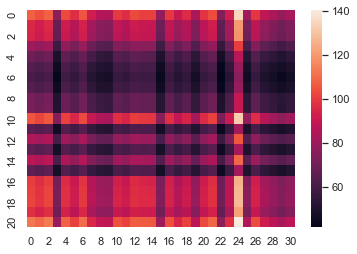

In [ ]:
sns.heatmap(q)

In [ ]:
th.argmax(q, -1)

tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24])

<AxesSubplot:xlabel='contributions', ylabel='punishments'>

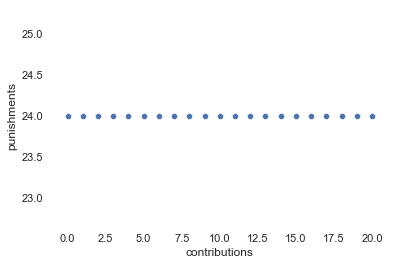

In [ ]:
import seaborn as sns
import pandas as pd

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

df = pd.DataFrame(data)
sns.scatterplot(data=data, x='contributions', y='punishments')

In [ ]:
from aimanager.utils.array_to_df import using_multiindex

def to_series(k, v):
    dims = ['episode', 'step', 'agent'][:len(v.shape)]
    sr = using_multiindex(v, dims).set_index(dims).rename(columns={"value": k})
    sr.name = k
    return sr
dfs = [to_series(k, v)
    for k, v in recorder.memory.items() if len(v.shape) <= 3
]
dfs = [df.reindex(dfs[0].index) for df in dfs]
rec_df = pd.concat(dfs, axis=1).reset_index(drop=True)

dfs = [to_series(k, v)
    for k, v in replay_mem.memory.items() if len(v.shape) <= 3
]
dfs.append(to_series('current_obs', th.argmax(replay_mem.memory['current_obs'], -1)))
dfs = [df.reindex(dfs[0].index) for df in dfs]
repm_df = pd.concat(dfs, axis=1).reset_index(drop=True)

<AxesSubplot:xlabel='punishments', ylabel='count'>

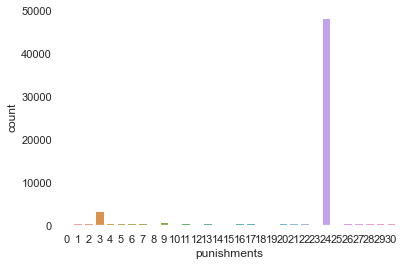

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rec_df, x='punishments')

<AxesSubplot:xlabel='prev_punishments', ylabel='count'>

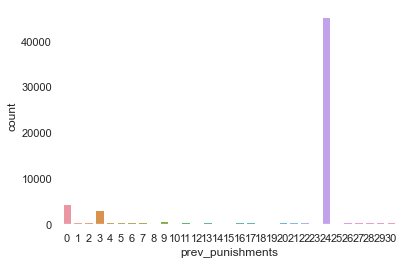

In [ ]:
sns.countplot(data=rec_df, x='prev_punishments')

<AxesSubplot:title={'center':'mean'}, xlabel='prev_contributions', ylabel='prev_punishments'>

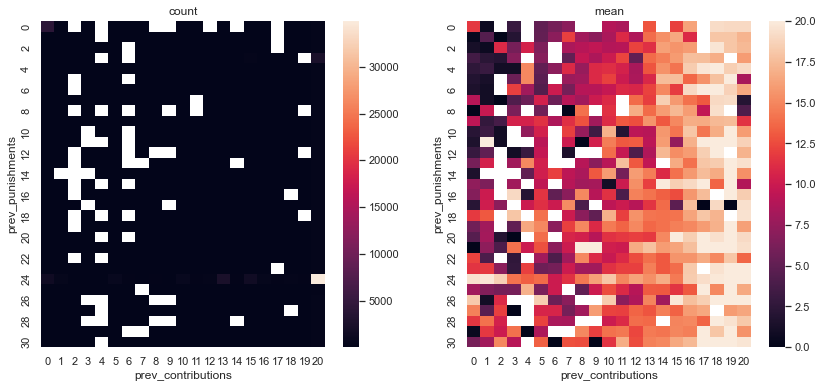

In [ ]:
df_count_pt = rec_df.pivot_table(index=['prev_punishments'], columns='prev_contributions', values='contributions', aggfunc=len)
df_mean_pt = rec_df.pivot_table(index=['prev_punishments'], columns='prev_contributions', values='contributions', aggfunc=np.mean)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title('count')
sns.heatmap(df_count_pt, ax=ax1)
ax2.set_title('mean')
sns.heatmap(df_mean_pt, ax=ax2)

In [ ]:
repm_df

,actions,rewards,episode,episode_steps,current_obs
0,29,-14.599999,899,0,15
1,24,-3.199999,899,0,7
2,24,8.000000,899,0,0
3,24,8.000000,899,0,10
4,24,-3.199999,899,1,9
...,...,...,...,...,...
5995,24,8.000000,998,13,20
5996,5,27.000000,998,14,20
5997,24,8.000000,998,14,20
5998,15,17.000000,998,14,20


<AxesSubplot:title={'center':'mean'}, xlabel='actions', ylabel='current_obs'>

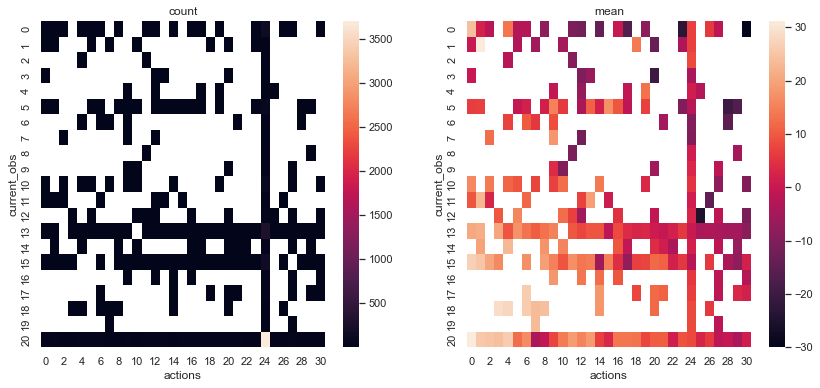

In [ ]:
df_count_pt = repm_df.pivot_table(index=['current_obs'], columns='actions', values='rewards', aggfunc=len)
df_mean_pt = repm_df.pivot_table(index=['current_obs'], columns='actions', values='rewards', aggfunc=np.mean)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title('count')
sns.heatmap(df_count_pt, ax=ax1)
ax2.set_title('mean')
sns.heatmap(df_mean_pt, ax=ax2)